## Create a polygon around the extent of the lidar study area  
Code adapted from David Shean

Load a reduced resolution overview for processing  
Assumes overviews have already been generated with `gdaladdo -r gauss`

### Load necessary packages

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#from astropy.time import Time
from datetime import datetime
import rasterio as rio
from rasterio import features
import rioxarray as rxr

In [11]:
%matplotlib inline

#### Load in the lidar data:

In [5]:
lidar_fn = '../data/aso_lidar/east_river_lidar/ASO_50M_SWE_USCOGE_20180331.tif'
lidar_fn2 = '../data/aso_lidar/east_river_lidar/ASO_50M_SWE_USCOGE_20190407.tif'

In [23]:
aso = rxr.open_rasterio(lidar_fn, masked=True).squeeze()
aso2 = rxr.open_rasterio(lidar_fn2, masked=True).squeeze()

In [3]:
extent = gpd.read_file('../data/east_river_from_ross.json')

<Axes: >

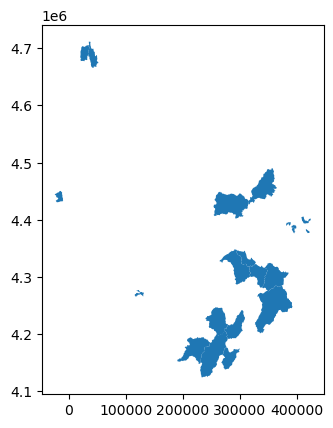

In [49]:
extent.plot()

In [4]:
extent = extent.set_crs('epsg:32613', allow_override=True)

In [5]:
er = extent[extent['gage']=='09112500']

In [56]:
er.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

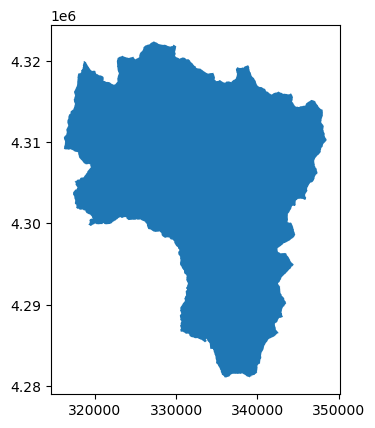

In [57]:
er.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

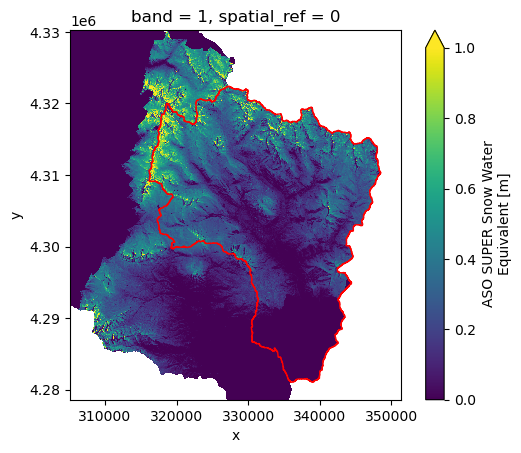

In [101]:
fig, ax = plt.subplots()

aso.plot(ax=ax,vmin=0,vmax=1)
er.plot(ax=ax, facecolor='none',edgecolor='red')

In [110]:
er.to_file('../data/misc/east_river_outline.geojson')

In [6]:
er = gpd.read_file('../data/misc/east_river_outline.geojson')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

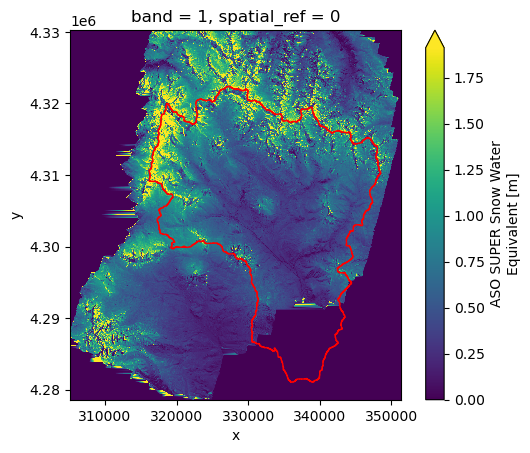

In [61]:
fig, ax = plt.subplots()

aso2.plot(ax=ax, robust=True)
er.plot(ax=ax, facecolor='none',edgecolor='red')

In [7]:
aso_poly_neg = gpd.read_file('../data/misc/neg_map.geojson')

In [8]:
aso_poly_neg = aso_poly_neg[0:1]
aso_poly_neg = aso_poly_neg.to_crs('epsg:32613')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

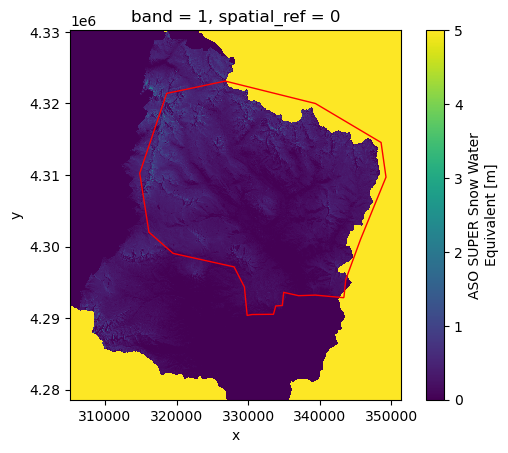

In [16]:
fig, ax = plt.subplots()
aso.plot(ax=ax, robust=True)
aso_poly_neg.plot(ax=ax, facecolor='none', edgecolor='red')
#aso_poly_neg2.plot(ax=ax, facecolor='none', edgecolor='orange')

<Axes: >

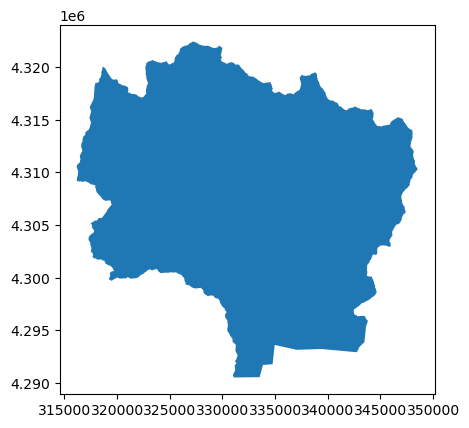

In [9]:
aso_poly_clip = gpd.clip(er,aso_poly_neg)
aso_poly_clip.plot()

In [10]:
aso_poly_clip.to_file('../data/misc/east_river_clipped.geojson')

### 2018

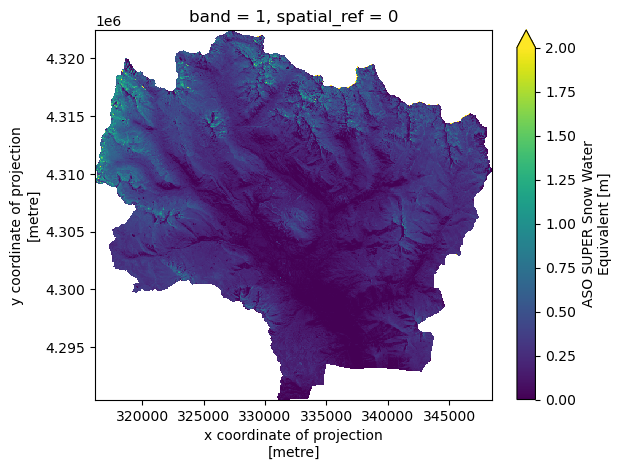

In [24]:
aso.values=np.where(np.isnan(aso), 5, aso)
aso_clipped = aso.rio.clip(aso_poly_clip.geometry.values, crs=aso_poly_clip.crs, drop=True)
aso_clipped.plot(add_colorbar=True,vmin=0, vmax=2)

### 2019

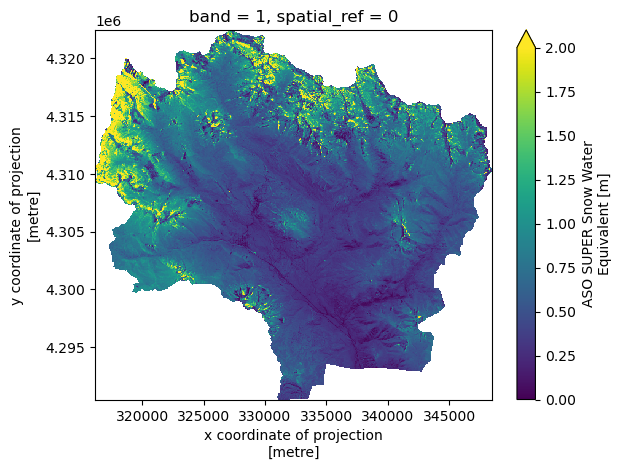

In [25]:
aso_2 = rxr.open_rasterio('../data/aso_lidar/east_river_lidar/ASO_50M_SWE_USCOGE_20190407.tif', all_touched=False,drop=True, masked=True) 
aso_2.values=np.where(np.isnan(aso_2), 5, aso_2)
aso2_clipped = aso_2.rio.clip(aso_poly_clip.geometry.values, crs=aso_poly_clip.crs, drop=True)
aso2_clipped.plot(add_colorbar=True,vmin=0, vmax=2)

In [26]:
aso_clipped.rio.to_raster('../data/aso_lidar/comparison_lidar/ASO_50M_SWE_USCOGE_20180331_clipped.tif')
aso2_clipped.rio.to_raster('../data/aso_lidar/comparison_lidar/ASO_50M_SWE_USCOGE_20190407_clipped.tif')

Form these features into a geodataframe:

### Do the same for Conejos:

In [1]:
lidar_fn = '../data/aso_lidar/conejos_lidar/ASO_50M_SWE_USCOCJ_20160403.tif'

In [5]:
# I only have one lidar file, so I pulled this code out of the for loop that was
# written by David Shean in his GrandMesa_analysis notebook.

lidar_feat_list = []
#ovr_scale = 8
dt_fieldnum = 4
src = rio.open(lidar_fn)
a = src.read(1, masked=True)
mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=src.transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(lidar_fn)[-1])[0].split('_')[dt_fieldnum]
lidar_feat_list.extend([{'properties':{'fn':lidar_fn, 'date':'2019'}, 'geometry':i[0]} for i in geom_list])

In [6]:
lidar_gdf = gpd.GeoDataFrame.from_features(lidar_feat_list, crs=src.crs)

In [7]:
lidar_gdf

,geometry,fn,date
0,"POLYGON ((368305.040 4138466.999, 368305.040 4...",../data/aso_lidar/conejos_lidar/ASO_50M_SWE_US...,2019


<Axes: >

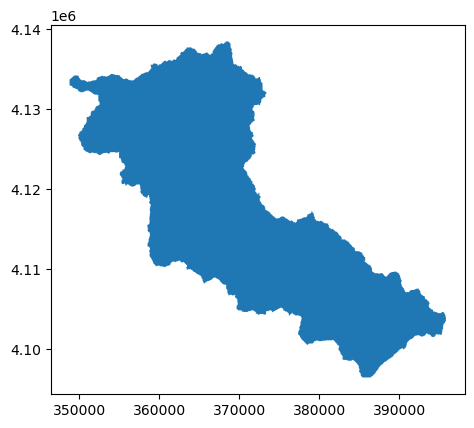

In [8]:
lidar_gdf.plot()

In [9]:
lidar_gdf.to_file('../data/misc/conejos_outline.geojson', driver='GeoJSON')